In [1]:
JOBFILE = '1vAll-MultinomialNB-f1_0.86-ap_0.932-COUNT-50-0.20-2019-07-16_15-58-44.job.gz'

In [3]:
import query_name_learner
import importlib
import seaborn
import matplotlib.pyplot as plt
import roc_utils
import numpy

importlib.reload(roc_utils)

Using TensorFlow backend.


<module 'roc_utils' from '/Users/asabornstein/cyberDNSDetection/cyberbg-attack-detection-dns/src/roc_utils.py'>

In [4]:
per_user_states = query_name_learner._load_stuff(JOBFILE)

In [8]:
# %load confusion_matrix.py
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def get_confusion_matrix(y_true, y_pred, normalize=True):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    return cm

def plot_confusion_matrix(y_true, y_pred, classes=None,
                          normalize=False,
                          add_to_title=None,
                          pdf_pages_export = None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        title = 'Normalized confusion matrix '
    else:
        title = 'Confusion matrix, without normalization '

    if (add_to_title != None):
        title += add_to_title
    
    # Compute confusion matrix
    cm = get_confusion_matrix(y_true, y_pred, normalize=normalize)
    
    # Only use the labels that appear in the data
    uniq_labels = unique_labels(y_true, y_pred)
    if classes:
        classes = classes[uniq_labels]
    else:
        classes = uniq_labels

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
#     fig

    if (pdf_pages_export != None):
        pdf_pages_export.savefig()
    
    plt.show()
    plt.close()
    return ax


In [9]:
# %load roc_utils.py
from sklearn.metrics import auc, f1_score, roc_curve, precision_recall_curve, average_precision_score
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def _plot(x, y, title, xlabel, ylabel, baseline=([0,1], [0,1]), pdf_pages_export = None):
    
    
    plt.figure()
    plt.plot(x, y, color='darkorange', lw=5, label=title)
    plt.plot(*baseline, color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc="lower right")   

    if (pdf_pages_export != None):
        pdf_pages_export.savefig()

    plt.show()
    plt.close()
    
        

def plot_roc_curve(y_true, y_pred_proba, add_info = '', pdf_pages_export = None):
    fpr, tpr, threshold = roc_curve(y_true, y_pred_proba[:,1])
    roc_auc_score = auc(fpr, tpr)
    print(roc_auc_score)
    title = f'ROC curve (area = {roc_auc_score:.4f}) {add_info}'

    _plot(fpr, tpr, title, 'False Positive Rate', 'True Positive Rate', baseline=([0,1],[0,1]), pdf_pages_export = pdf_pages_export)

def plot_precision_recall_curve(y_true, y_pred_proba, beta=1.0, add_info = '', pdf_pages_export = None):
    positive_proba = y_pred_proba[:,1]
    precision, recall, thresholds = precision_recall_curve(y_true, positive_proba)
    plt.figure()
    ap_score = average_precision_score(y_true, positive_proba)
    print(ap_score)
   
    title = f'Precision-Recall curve (ap-score = {ap_score:.3f}) {add_info}'

    _plot(precision, recall, title, 'Precision', 'Recall', baseline=([0,1],[0.5,0.5]), pdf_pages_export = pdf_pages_export)


In [14]:
def merge_all_users_stats(per_user_states):

    y_test = np.empty([0])
    y_test_pred = np.empty([0])
    y_test_proba = np.empty([0])
    
    for user, s in per_user_states.items():
        
        y_test = np.append(y_test,s.y_test)
        y_test_pred = np.append(y_test_pred,s.y_test_pred)
        
        if (y_test_proba.size == 0):
            y_test_proba = s.y_test_proba
        else:
            y_test_proba = np.concatenate((y_test_proba, s.y_test_proba), axis = 0)
        
    test_results = type('testResults', (object,), 
                 {'y_test':y_test, 'y_test_pred':y_test_pred, 'y_test_proba':y_test_proba})()
    
    
    return test_results

In [10]:
def plot_roc_curve_per_user(per_user_states, pdf_pages_export = None):
    for user, s in per_user_states.items():
        print(f'ROC Curve for {user}')
        roc_utils.plot_roc_curve(s.y_test, s.y_test_proba, add_info = f'for {user}', pdf_pages_export = pdf_pages_export)
    
def plot_roc_curve_for_all_users(per_user_states, pdf_pages_export):
        merged_results = merge_all_users_stats(per_user_states)
        print(f'ROC Curve for all users')
        roc_utils.plot_roc_curve(merged_results.y_test, merged_results.y_test_proba, add_info = f'for all users', pdf_pages_export = pdf_pages_export)

        

In [11]:
def plot_precision_recall_curve_per_user(per_user_states, pdf_pages_export = None):
    for user, s in per_user_states.items():
        print(f'Precision-Recall Curve for {user}')
        roc_utils.plot_precision_recall_curve(s.y_test, s.y_test_proba, add_info = f'for {user}', pdf_pages_export = pdf_pages_export)
    
def plot_precision_recall_curve_for_all_users(per_user_states, pdf_pages_export = None):
        merged_results = merge_all_users_stats(per_user_states)
        print(f'Precision-Recall Curve for all users')
        roc_utils.plot_precision_recall_curve(merged_results.y_test, merged_results.y_test_proba, add_info = f'for all users', pdf_pages_export = pdf_pages_export)


In [12]:
import confusion_matrix

importlib.reload(confusion_matrix)

def plot_confusion_matrix_for_users(per_user_states, normalize = True, pdf_pages_export = None):
    
    for user, s in per_user_states.items():
        
        confusion_matrix.plot_confusion_matrix(s.y_test, s.y_test_pred, normalize = normalize, add_to_title = f'for {user}', pdf_pages_export = pdf_pages_export)
    
def plot_confusion_matrix_for_all_users(per_user_states, normalize = True, pdf_pages_export = None):
    
    merged_results = merge_all_users_stats(per_user_states)
        
    confusion_matrix.plot_confusion_matrix(merged_results.y_test, merged_results.y_test_pred, normalize = normalize, add_to_title = f'for all users', pdf_pages_export = pdf_pages_export)

    

Plotting ROC curves
ROC Curve for user343
0.980490576022163


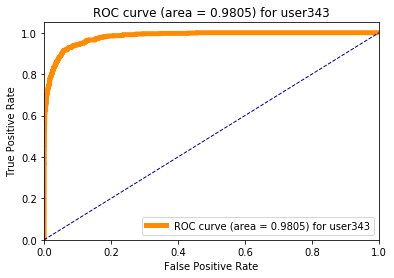

ROC Curve for user372
0.9915293032619759


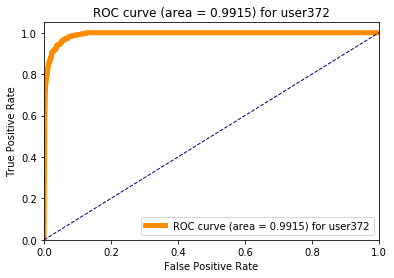

ROC Curve for user308
0.9948593659861267


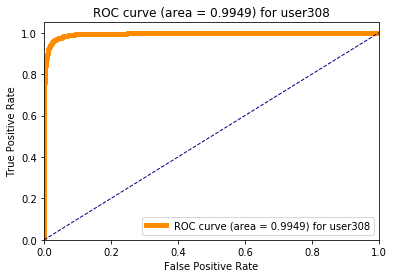

ROC Curve for user292
0.9948958191703646


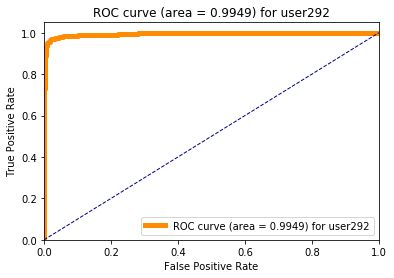

ROC Curve for user392
0.9962935969419932


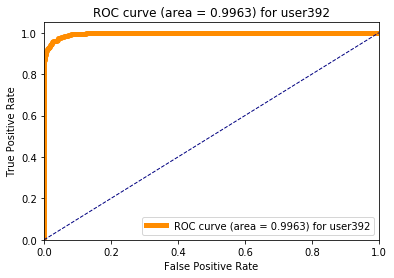

ROC Curve for user341
0.9946307464956662


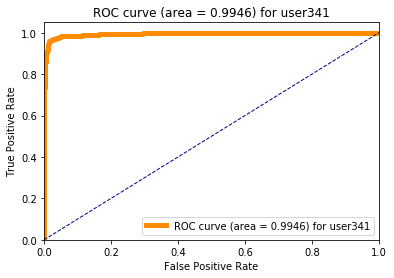

ROC Curve for user316
0.988325678690149


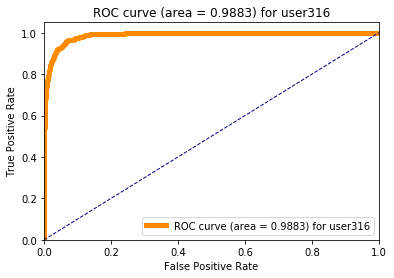

ROC Curve for user303
0.9932345688894225


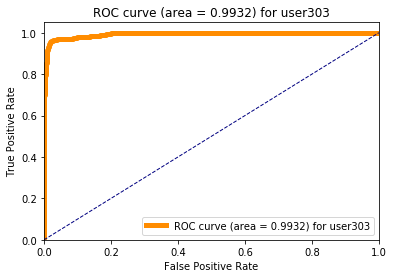

ROC Curve for user354
0.9820293719964487


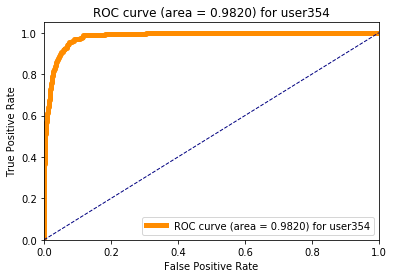

ROC Curve for user348
0.9987160080012975


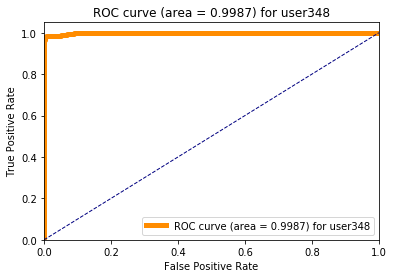

ROC Curve for user306
0.9915497244649494


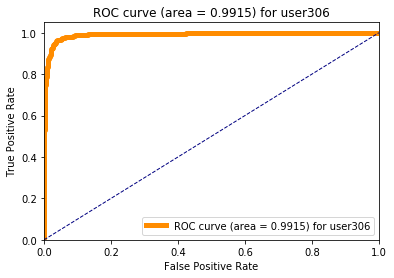

ROC Curve for user334
0.9906195456781095


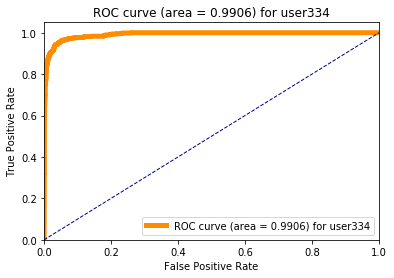

ROC Curve for user387
0.9801187694204698


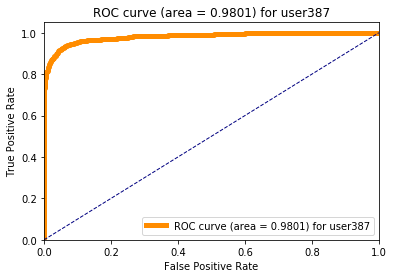

ROC Curve for user305
0.9972710299198935


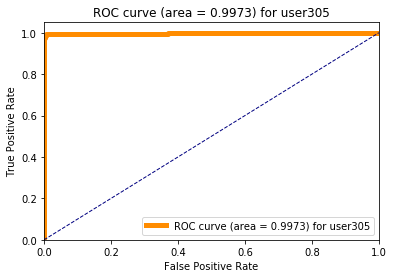

ROC Curve for user301
0.9959723302376151


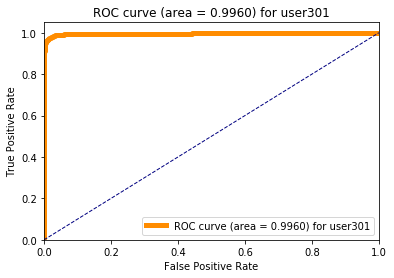

ROC Curve for all users
0.9917246381928462


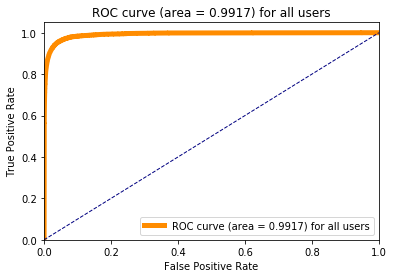

Plotting precision-recall curves
Precision-Recall Curve for user343
0.8779642429275968


<Figure size 432x288 with 0 Axes>

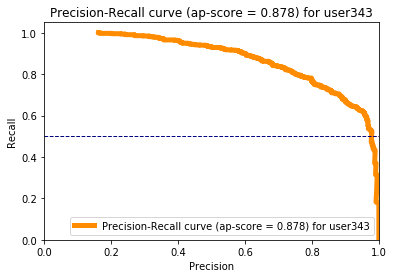

Precision-Recall Curve for user372
0.895158927084905


<Figure size 432x288 with 0 Axes>

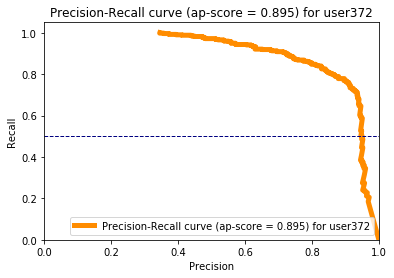

Precision-Recall Curve for user308
0.9472724570319314


<Figure size 432x288 with 0 Axes>

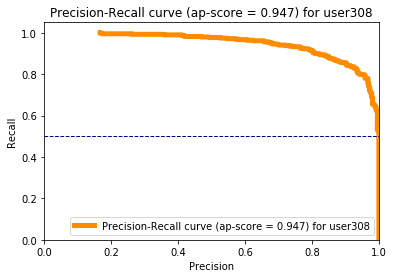

Precision-Recall Curve for user292
0.9647624371782824


<Figure size 432x288 with 0 Axes>

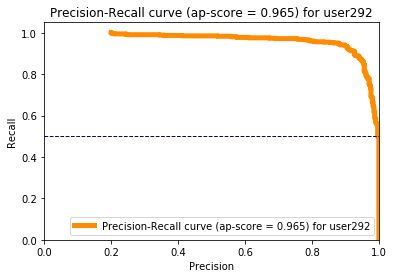

Precision-Recall Curve for user392
0.9688925604401313


<Figure size 432x288 with 0 Axes>

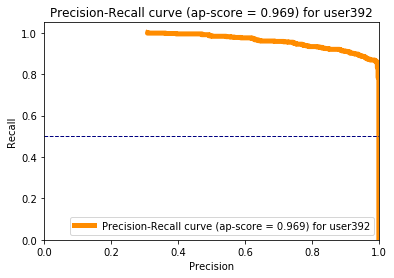

Precision-Recall Curve for user341
0.9571279647557082


<Figure size 432x288 with 0 Axes>

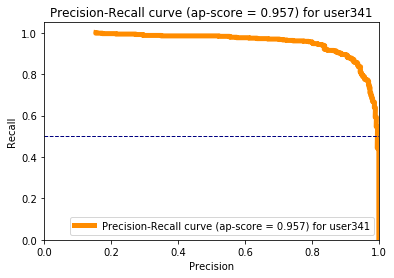

Precision-Recall Curve for user316
0.8820624242895283


<Figure size 432x288 with 0 Axes>

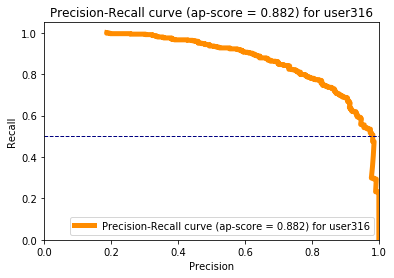

Precision-Recall Curve for user303
0.9573309890810914


<Figure size 432x288 with 0 Axes>

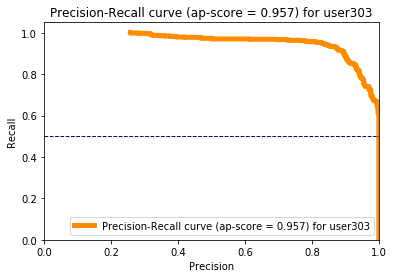

Precision-Recall Curve for user354
0.7980408652836118


<Figure size 432x288 with 0 Axes>

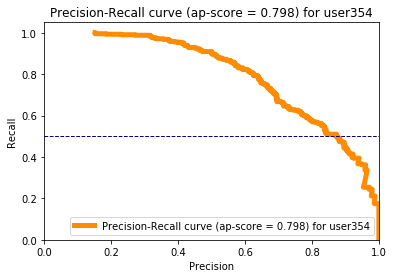

Precision-Recall Curve for user348
0.9877649393453051


<Figure size 432x288 with 0 Axes>

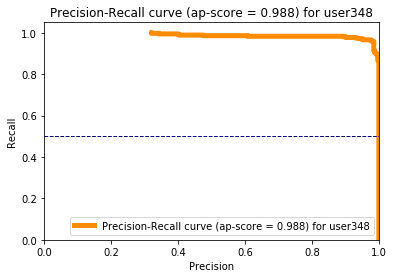

Precision-Recall Curve for user306
0.9116727482610305


<Figure size 432x288 with 0 Axes>

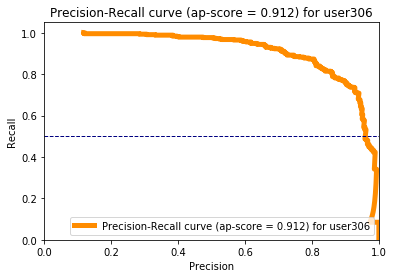

Precision-Recall Curve for user334
0.9287663456284623


<Figure size 432x288 with 0 Axes>

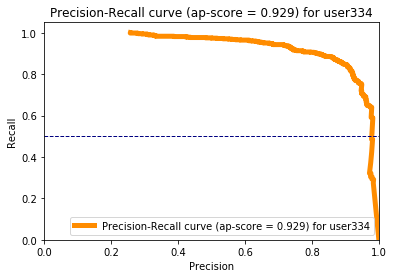

Precision-Recall Curve for user387
0.9140281218141075


<Figure size 432x288 with 0 Axes>

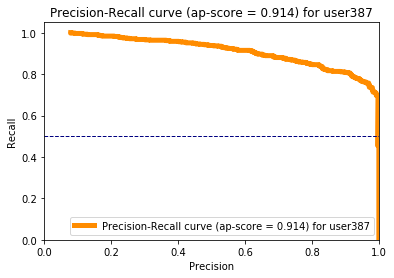

Precision-Recall Curve for user305
0.9943572999911201


<Figure size 432x288 with 0 Axes>

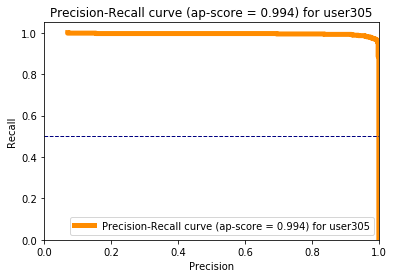

Precision-Recall Curve for user301
0.9874651852052209


<Figure size 432x288 with 0 Axes>

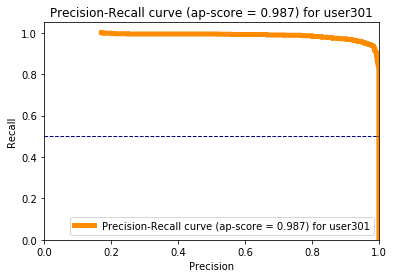

Precision-Recall Curve for all users
0.9366394243887608


<Figure size 432x288 with 0 Axes>

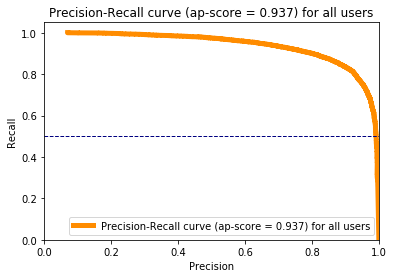

Plotting normalized confusion matrices


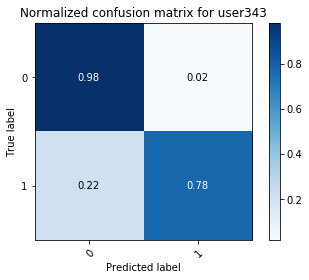

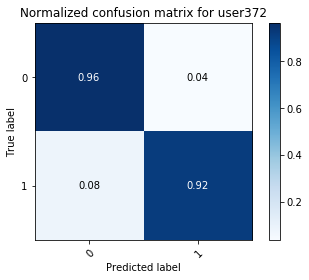

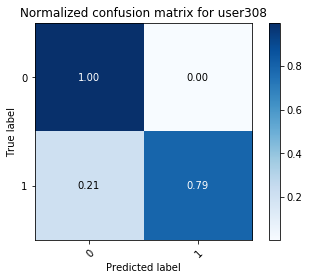

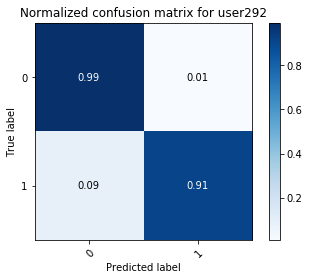

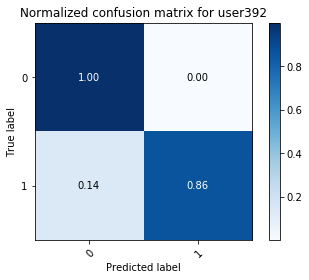

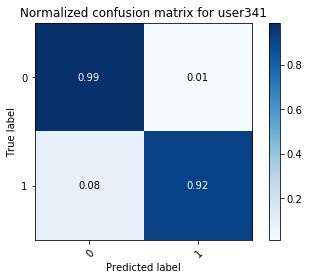

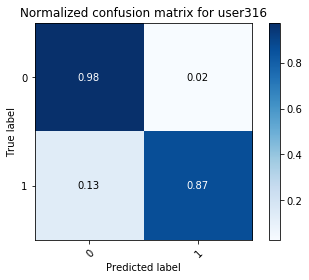

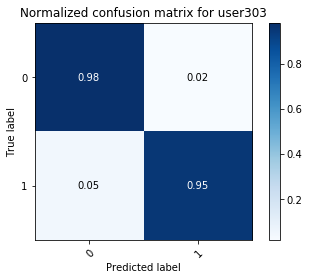

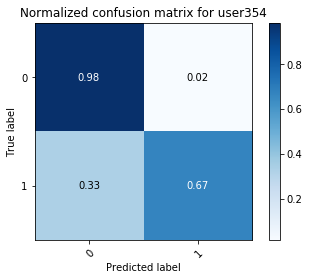

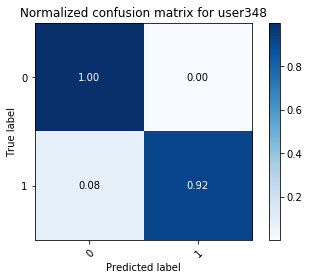

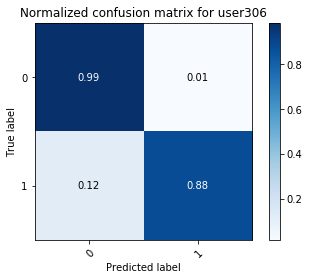

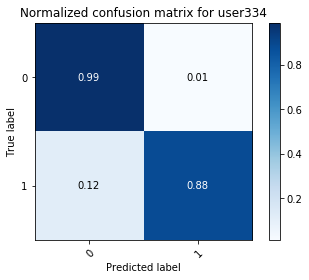

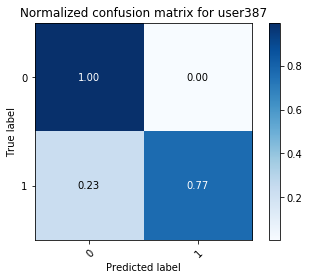

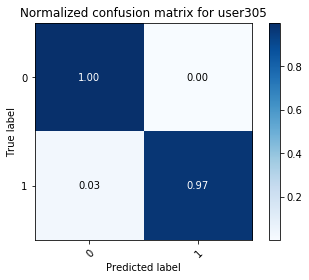

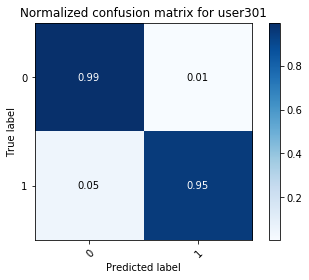

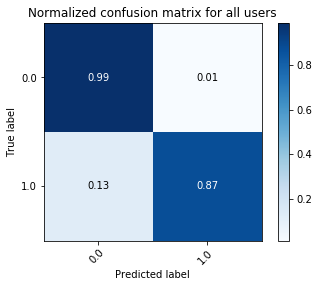

Plotting unnormalized confusion matrices


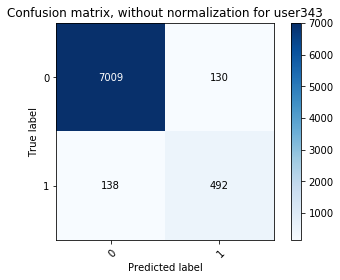

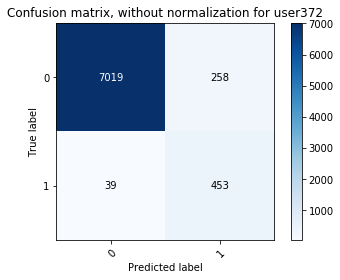

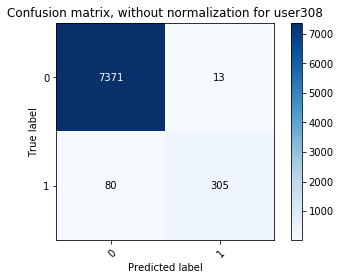

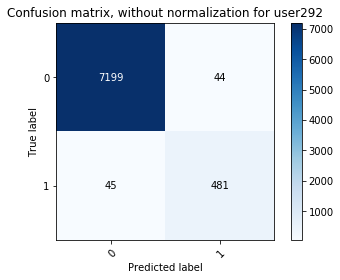

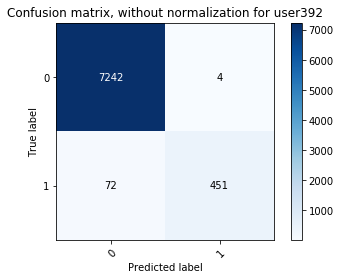

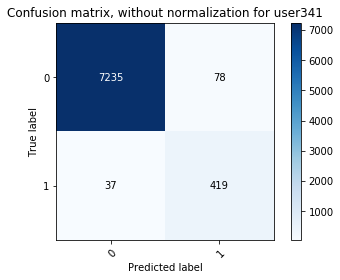

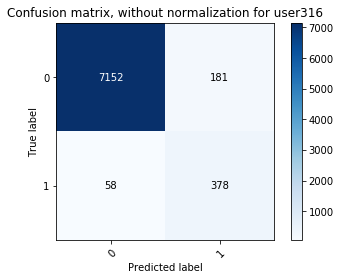

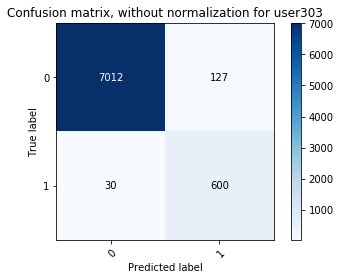

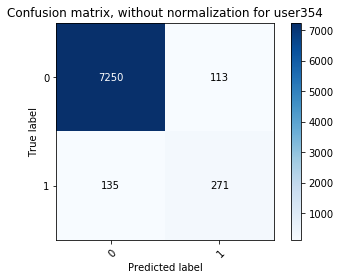

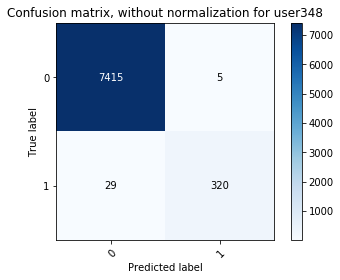

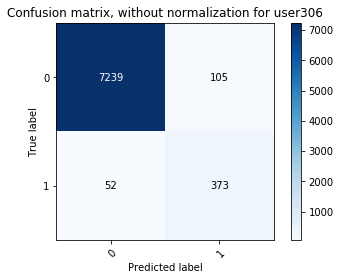

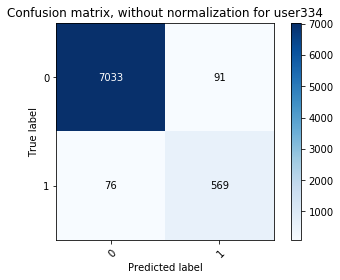

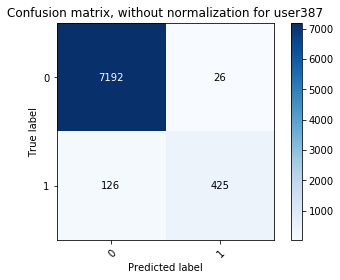

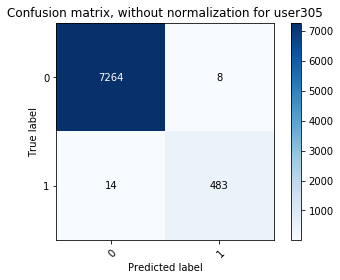

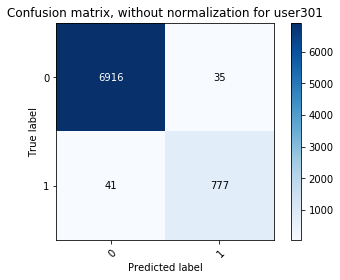

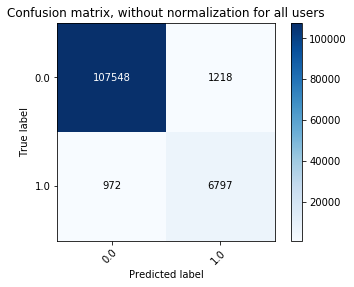

In [15]:
pdfFileName = JOBFILE + '.pdf'

with PdfPages(pdfFileName) as pdf_pages_export:    
  
    print(f'Plotting ROC curves')
    
    plot_roc_curve_per_user(per_user_states, pdf_pages_export)
    plot_roc_curve_for_all_users(per_user_states, pdf_pages_export)

    print(f'Plotting precision-recall curves')

    plot_precision_recall_curve_per_user(per_user_states, pdf_pages_export)
    plot_precision_recall_curve_for_all_users(per_user_states, pdf_pages_export)

    print(f'Plotting normalized confusion matrices')

    plot_confusion_matrix_for_users(per_user_states,normalize =  True, pdf_pages_export = pdf_pages_export)
    plot_confusion_matrix_for_all_users(per_user_states, normalize =  True, pdf_pages_export = pdf_pages_export)
    
    print(f'Plotting unnormalized confusion matrices')

    plot_confusion_matrix_for_users(per_user_states,normalize =  False, pdf_pages_export = pdf_pages_export)
    plot_confusion_matrix_for_all_users(per_user_states, normalize =  False, pdf_pages_export = pdf_pages_export)

